# Lecture #4: Implementing Tools from Paper \#1
## The zeroth step: Importing, Understanding and Cleaning the Data

In this lecture we will learn about two things: Exploratory Data Analysis (EDA) and clustering. The first, is a set of techniques that are used to better understand datasets and enable the postulation of useful hypotheses that can later be tested more formally. The latter is a set of techniques used to discover patterns and structure in a dataset, in an unsupervised manner. 

To do this, we will be using a dataset of the energy demand for some campus buildings, as well as the temperature around campus. Because there was a similar assignment using this dataset in 2014, the whole document is based on that assignment and has been extended to reflect the specific tools and techniques used in Paper #1 for our 2017 course.

We begin by importing all of the libraries that are necessary, and setting up the plotting environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import itertools

%matplotlib inline

/Users/mberges/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Then, we import a csv file containing the campus electricity demand into a variable called *data*. This valriable will be a Pandas Data Frame. We leverage a new lambda function that will allow the importer to convert the timestamp strings into datetime objects:

In [2]:
f = open('data/campusDemand.csv')
data = pd.read_csv(f,sep=',', header='infer', parse_dates=[1])

## Data inspection and clean-up

First let's see the first few lines:

In [3]:
data.head()

,Point name,Time,Value,Rendered,Annotation
0,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:00:50,80635.421875,80635 Watts,NaN
1,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:01:50,77046.992188,77047 Watts,NaN
2,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:02:50,76787.828125,76788 Watts,NaN
3,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:03:50,79804.031250,79804 Watts,NaN
4,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:04:50,79397.078125,79397 Watts,NaN


Now let's see the last few lines:

In [4]:
data.tail()

,Point name,Time,Value,Rendered,Annotation
744887,Baker Hall Electric (Shark 29) - Demand Watts,2014-11-10 20:04:28,197454.37500,197454.375,NaN
744888,Baker Hall Electric (Shark 29) - Demand Watts,2014-11-10 20:34:28,195065.00000,195065.0,NaN
744889,Baker Hall Electric (Shark 29) - Demand Watts,2014-11-10 21:04:28,190167.78125,190167.78125,NaN
744890,Baker Hall Electric (Shark 29) - Demand Watts,2014-11-10 21:34:28,188231.90625,188231.90625,NaN
744891,Baker Hall Electric (Shark 29) - Demand Watts,2014-11-10 22:04:28,182980.18750,182980.1875,NaN


At this point, I can see that the last two columns are not very interesting/important, so let's delete them.

In [5]:
data = data.drop(data.columns[[3,4]],axis=1)

Let's now make sure the columns that remain are the right ones:

In [6]:
data.columns

Index(['Point name', 'Time', 'Value'], dtype='object')

Let's show the first few samples in the "Point name" column:

In [7]:
data['Point name'].head()

0    Porter Hall Electric (Shark 30) - Watts
1    Porter Hall Electric (Shark 30) - Watts
2    Porter Hall Electric (Shark 30) - Watts
3    Porter Hall Electric (Shark 30) - Watts
4    Porter Hall Electric (Shark 30) - Watts
Name: Point name, dtype: object

One of the very useful methods that come with the DataFrame object is **describe()**. It provides us with basic statistics for the columns in the data frame:

In [8]:
data.describe()

,Value
count,744892.000000
mean,50440.790518
std,93628.102665
min,0.000000
25%,8460.539906
50%,9828.554625
75%,66911.550781
max,917585.375000


At this point you may be wondering, a few things. For example, why did the **describe** method not provide any statistics for the other columns? Well, this is because the other columns are not numerical. Pandas can describe numerical data and objects, but as it says in the documentation: "For mixed data types provided via a DataFrame, the default is to return only an analysis of numeric columns".

If we wanted to describe the Time column, we could do as such:

In [19]:
data['Time'].describe()

count                  744892
unique                 670135
top       2014-11-02 01:34:24
freq                        6
first     2013-11-10 00:00:30
last      2014-11-10 22:53:27
Name: Time, dtype: object

And you could do the same for the other columns. For instance:

In [20]:
data['Point name'].describe()

count                                        744892
unique                                            7
top       Electric kW Calculations - Main Campus kW
freq                                         522410
Name: Point name, dtype: object

Here, we finally see that the dataset has a total of 7 electrical meters in it. Another way to find find the unique number of point names, is to use the unique function from Numpy, and apply it to the 'Point_name' column in *data*, or to use a built-in method called unique available for Pandas DataFrames:

In [21]:
# Both of these are equivalent, but the second one is the Pandas way to do it.

#pointNames = np.unique(data['Point name'])
pointNames = data['Point name'].unique()

print('There are {} unique meters.'.format(pointNames.shape[0]))

There are 7 unique meters.


We can now print the contents of the *pointNames* array:

In [22]:
print(pointNames)

['Porter Hall Electric (Shark 30) - Watts'
 'Baker Hall Electric (Shark 29) - Watts'
 'Scaife Hall Electric (Shark 21) - Watts'
 'Doherty Apts Electric (Shark 11) - Demand Watts'
 'University Center Electric (Shark 34) - Watts'
 'Electric kW Calculations - Main Campus kW'
 'Baker Hall Electric (Shark 29) - Demand Watts ']


### Are the samples equally spaced in time?

When the data you are analyzing is a time-series, it is often a good idea to ensure you understand its temporal structure. For instance, are all the samples collected at fixed intervals of time? Are there any temporal gaps?

As a first step, let's inspect data from one of the meters (e.g., the second one in the list above). Specifically, let's create a scatter plot of the Time column against the row number. Ideally this should be a straight line, but if there are discontinuities in the sampling process, then they will also appear as discontinuities in this line.

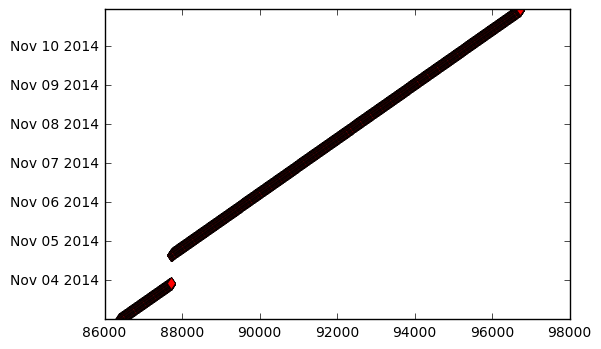

In [11]:
# There are many ways to do this, but here are two:

#plt.plot(data[(data['Point name'].isin([pointNames[1]]))]['Time'],'rd')
plt.plot(data[data['Point name'] == pointNames[1]]['Time'],'rd')

To count the numer of samples present on each power meter, there are many ways to achieve it. For instance, we can use an iterator to loop over all pointNames and create a list of tuples in the process (this is formally called a [List Comprehension](https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions)). Every tuple will then contain two elements: the meter name, and the number of samples in it:

In [23]:
pd.DataFrame(
    [(pn, len(data[data['Point name'] == pn])) for pn in pointNames],
    columns=['Point name','Number of samples']
)


,Point name,Number of samples
0,Porter Hall Electric (Shark 30) - Watts,86381
1,Baker Hall Electric (Shark 29) - Watts,10342
2,Scaife Hall Electric (Shark 21) - Watts,44819
3,Doherty Apts Electric (Shark 11) - Demand Watts,744
4,University Center Electric (Shark 34) - Watts,10062
5,Electric kW Calculations - Main Campus kW,522410
6,Baker Hall Electric (Shark 29) - Demand Watts,70134


Obviously, each meter has recorded different number of samples, so we need to better understand how long (temporally) are each of these time series.

Before going any further, let's confirm that the data types for our columns are what we expect (I expect the time column to be a datetime object, and the value to be a float).

In [13]:
data.dtypes

Point name            object
Time          datetime64[ns]
Value                float64
dtype: object

## How much time did each meter record for?

First, we can use another List Comprehension to iterate over the point names and create a new list whose elements are in turn tuples with the indeces for the samples corresponding to this meter. Then we can iterate over them and print the time by doing a simple difference (since the values in the 'Time' column are datetime objects, subtracting them generates a time_delta object that Python can interpret.

In [26]:
idx = [np.where(data['Point name']==meter) for meter in pointNames]

print('idx is now a {0} of {1} items.'.format(type(idx),len(idx)))
print('Each item in idx is of {0}.\n'.format(type(idx[0])))

for meterNo, meterRows in enumerate(idx):
    print("{} recorded for {}.".format(pointNames[meterNo], data['Time'].iloc[meterRows[0][-1]] - data['Time'].iloc[meterRows[0][0]]))



idx is now a <class 'list'> of 7 items.
Each item in idx is of <class 'tuple'>.

Porter Hall Electric (Shark 30) - Watts recorded for 61 days 22:41:38.
Baker Hall Electric (Shark 29) - Watts recorded for 7 days 22:43:04.
Scaife Hall Electric (Shark 21) - Watts recorded for 31 days 22:45:13.
Doherty Apts Electric (Shark 11) - Demand Watts recorded for 31 days 12:38:32.
University Center Electric (Shark 34) - Watts recorded for 7 days 22:48:04.
Electric kW Calculations - Main Campus kW recorded for 365 days 22:52:57.
Baker Hall Electric (Shark 29) - Demand Watts  recorded for 271 days 15:01:01.


## Yes, each meter measured a different time duration, but where are the temporal gaps?

For this task, we are going to directly take the difference between any two consecutive datetime objects and display the result in terms of, say, number of seconds elapsed between these timestamps. 

Before we do this, though, it is useful to plot the timestamps to figure out if there are discontinuities that we can visually see:

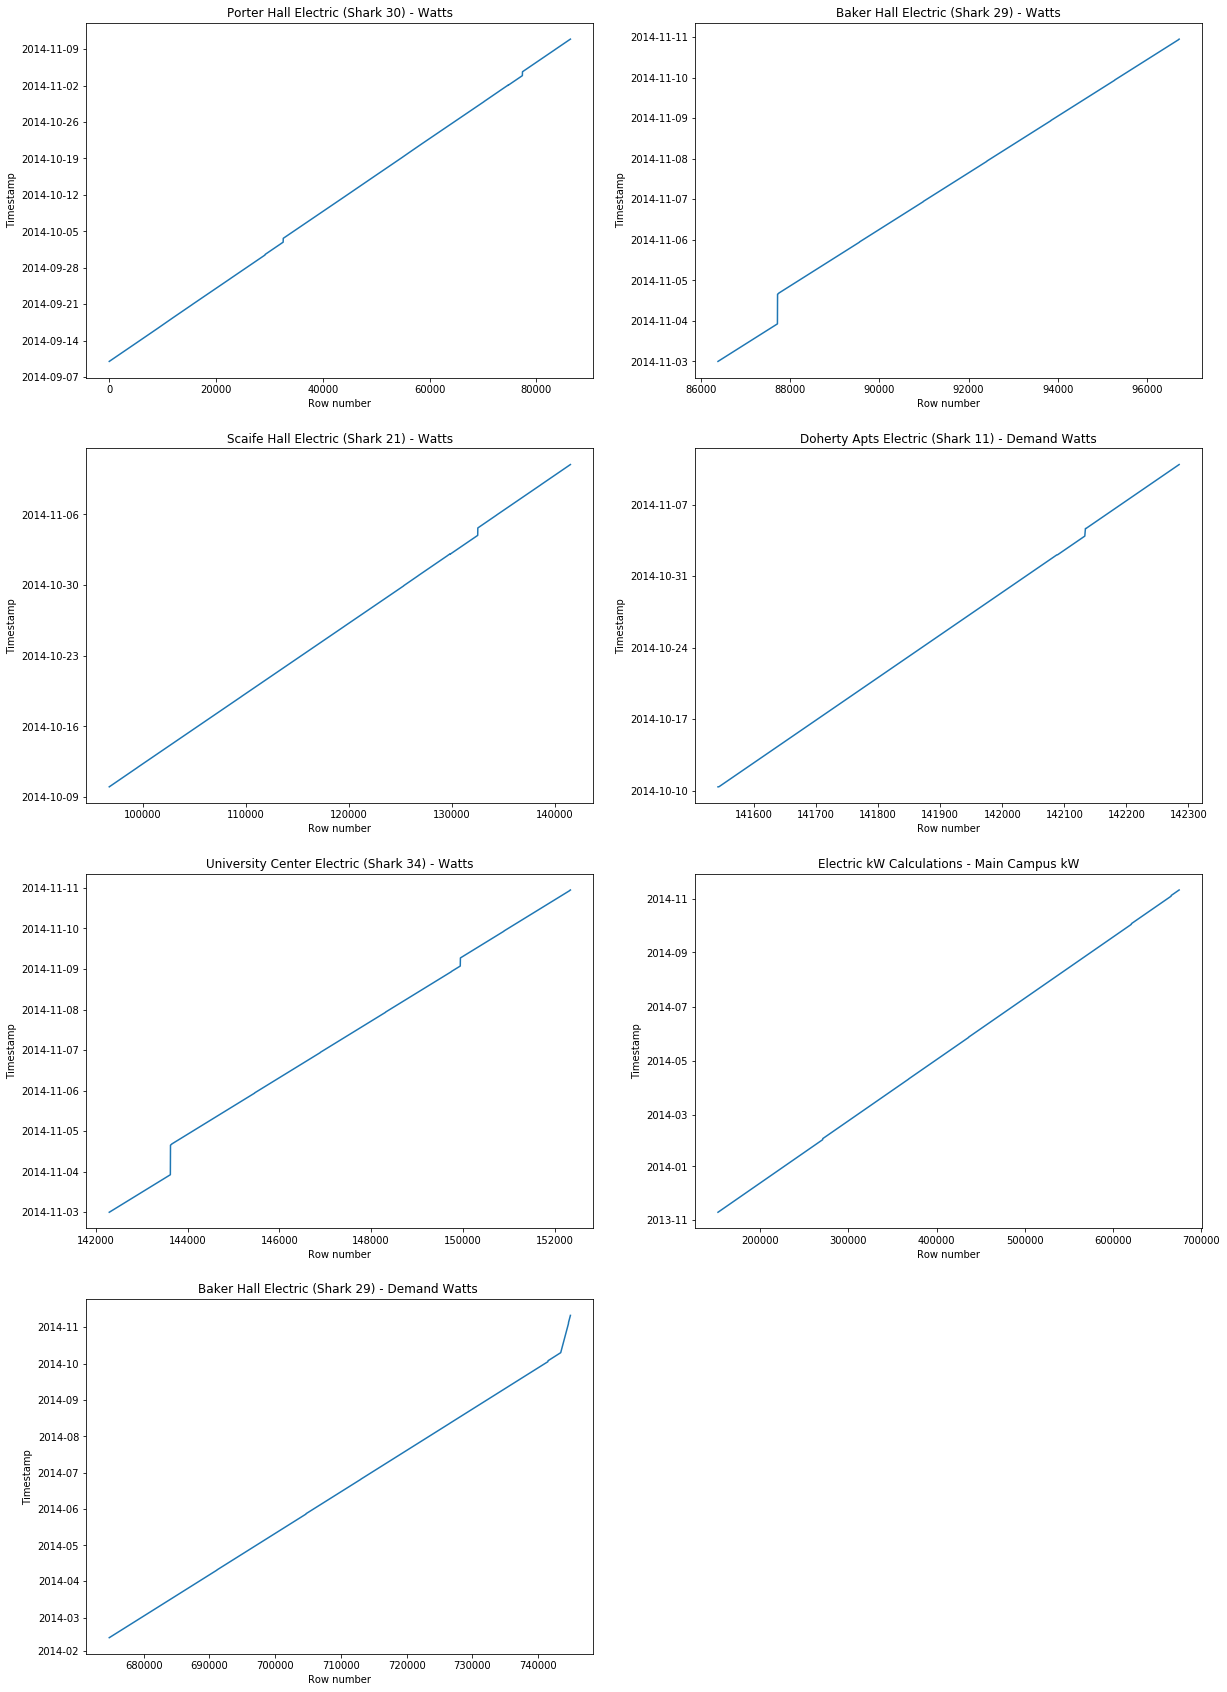

In [24]:
fig = plt.figure(figsize=(20,30)) # A 20 inch x 30 inch figure box

for meter,i in zip(pointNames,range(len(pointNames))):
    plt.subplot(4,2,i+1) # 4 rows and 2 columns of subplots
    plt.plot(data[data['Point name']==meter]['Time'])
    plt.title(meter)
    plt.xlabel('Row number')
    plt.ylabel('Timestamp')


As you may have seen, gaps were easily identifiable as discontinuities in the lines that were plotted. If no gaps existed, the plot would be a straight line.

But now let's get back to solving this using exact numbers...

First, you need to know that applying the difference operator (-) on two datetime objects results in a [timedelta](https://docs.python.org/2/library/datetime.html#datetime.timedelta) object. These objects (timedelta) describe time differences in terms of number of days, seconds and microseconds (see the link above for more details). 

Because of this, we could quickly convert any timedelta object (say *dt*) into the number of seconds by doing:
<pre>
dt.days*3600*24+dt.seconds+dt.microseconds/1000000
</pre>

In this case, however, our timestamps do not contain information about the microseconds, so we will skip that part of the converstion. 

All that said, what we are using are not timedelta objects per se, but rather timedelta64  objects (which are part of pandas) and they will spare us much trouble and we don't need to do the conversion anymore in this way. Much easier ways are available if you look through the documentation [here](http://pandas.pydata.org/pandas-docs/stable/timedeltas.html#frequency-conversion).

Using this knowledge, we can create a list of lists (a nested list) in a similar manner as we've done before (i.e. using list comprehensions), and in it store the timedeltas in seconds for each meter. In other words, the outer list is a list of the same length as pointNames, and each element is a list of timedeltas for the corresponding meter.

One more thing comes in handy for this task: the np.diff function, which takes an array (or a list) and returns the difference between any two consecutive items of the list.

Now, in a single line of code we can get the nested list we talked about:


In [27]:
delta_t = [[d/np.timedelta64(1, 'D') for d in np.diff(data['Time'].iloc[i[0]])] for i in idx]

Now we need to be able to print out the exact times during which there are gaps. We will define gaps to be any timedelta that is longer than the median timedelta for a meter.

We will achieve this as follows: 

- first we will create a for loop to iterate over every item in the list delta_t (which means we will iterate over all meters).
- then, inside the loop, we will calculate the median value for the delta_t that corresponds to each meter
- following this, we will find the indeces of delta_t where its value is greater than the median
- lastly, we will iterate over all the indeces found in the previous step and print out their values


In [17]:
np.set_printoptions(threshold=np.nan)

for i in range(len(delta_t)):
    resolution = np.median(delta_t[i]) # use median as the resolution
    gap_idx = np.where(np.array(delta_t[i]) > (resolution)) # define the gap to be the delta_t> resolution
    # print out the gap for each power meter
    print("-=-=-=-=-=-=-=-=-\n{}\nresolution:{}\ngaps:".format(pointNames[i],resolution))
    # This is pretty slow, so uncomment and run only if you want to see the output.
    #for the_idx in gap_idx[0]:
    #    print(data['Time'].iloc[idx[i]].iloc[the_idx],' to ',data['Time'].iloc[idx[i]].iloc[the_idx+1])
        
np.set_printoptions(threshold=8)

-=-=-=-=-=-=-=-=-
Porter Hall Electric (Shark 30) - Watts
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Baker Hall Electric (Shark 29) - Watts
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Scaife Hall Electric (Shark 21) - Watts
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Doherty Apts Electric (Shark 11) - Demand Watts
resolution:0.041666666666666664
gaps:
-=-=-=-=-=-=-=-=-
University Center Electric (Shark 34) - Watts
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Electric kW Calculations - Main Campus kW
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Baker Hall Electric (Shark 29) - Demand Watts 
resolution:0.003472222222222222
gaps:


### Due to weekly patterns it may be useful to separate the data by day of the week

First, we will define a new variable containing the weekday for each of the timestamps.

In [44]:
week_days = np.array([x.to_pydatetime().weekday() for x in data['Time']])

Monday = data.iloc[week_days == 0]
Tuesday = data.iloc[week_days == 1]
Wednesday = data.iloc[week_days == 2]
Thursday = data.iloc[week_days == 3]
Friday = data.iloc[week_days == 4]
Saturday = data.iloc[week_days == 5]
Sunday = data.iloc[week_days == 6]

All = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

## Creating daily load curves

In this task we basically use two for loops and the subplot functionality of PyPlot to do visualize the data contained in the variables we declared above.

The main trick is that we need to create a time index that only contains information about the hours, minutes and seconds (i.e. it completely disregards the exact day of the measurement) so that all of the measurements can be displayed within a single 24-hour period.

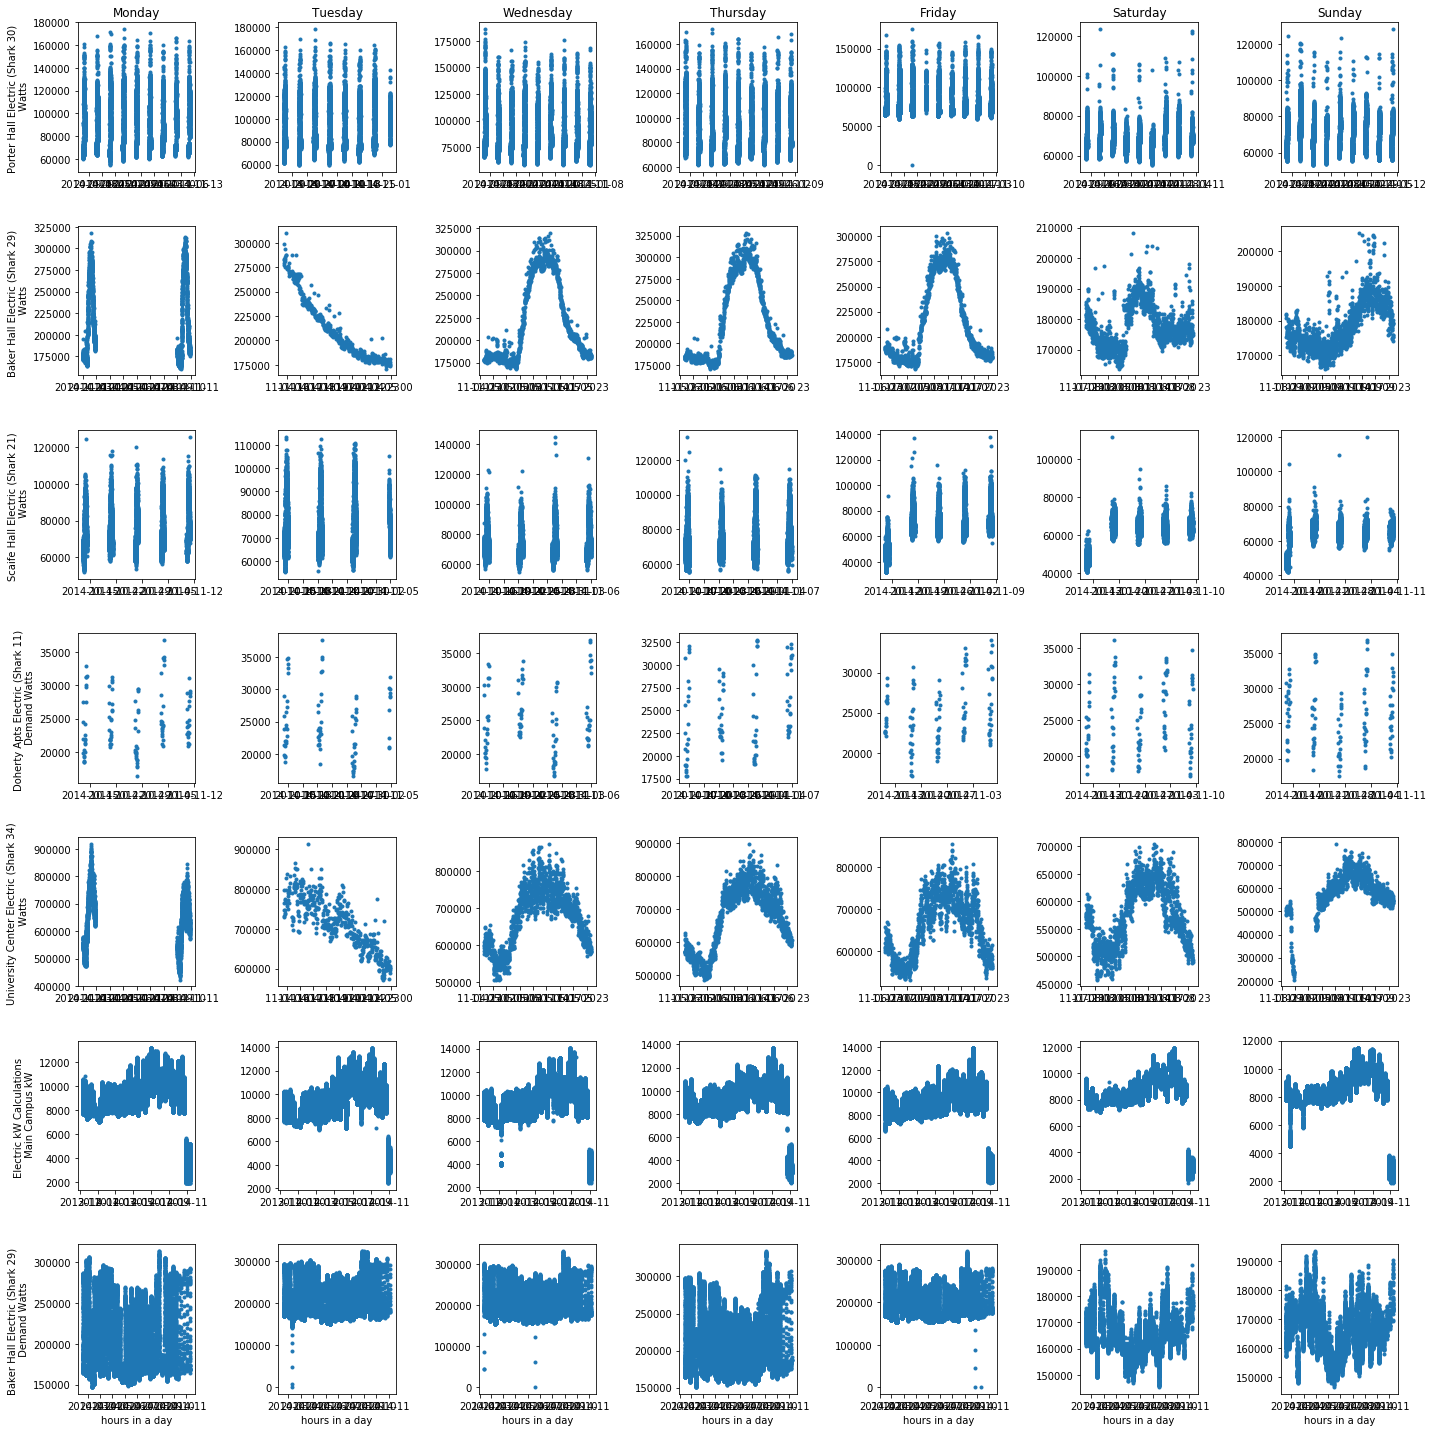

In [47]:
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.figure(figsize=(20,20))
for i in range(len(pointNames)): # iterate over meters
    for j in range(7): # iterate over days of the week
        plt.subplot(7,7,i*7+j+1)
        # Data from the day being plotted = All[j]
        # Data from the meter being plotted = All[j][All[j]['Point_name']==pointNames[i]]
        time = np.array(All[j]['Time'].loc[All[j]['Point name']==pointNames[i]])
        # plot the power vs the hours in a day
        plt.plot(time,All[j]['Value'].loc[All[j]['Point name']==pointNames[i]],'.')
        if i==6:
            plt.xlabel('hours in a day')
        if j==0: 
            plt.ylabel(pointNames[i].split('-')[0]+'\n'+pointNames[i].split('-')[1])
        if i==0:
            plt.title(Days[j])
fig.tight_layout()
plt.show()

From this analysis, we can draw serveral findings:

- Campus consume more energy during weekdays than weekends.
- Higher energy consumption during working hours.
- Many meters report a bi-modal distribution of the measurements, possibly due to seasonal effects.
- Some meters (e.g., Porter Hall) show more erratic behavior during weekends.

Finally, let's save the Pandas Data Frame to disk by Pickling it (see the Python reference for [Pickle](https://docs.python.org/3/library/pickle.html)):

In [48]:
import pickle

pickle_file = open('data/campusDemand.pkl','wb')
pickle.dump([data,pointNames,All,idx],pickle_file)
pickle_file.close()